In [1]:
# Install necessary libraries for Nucleotide Transformer Model
!pip install -q biopython transformers datasets huggingface_hub accelerate
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [2]:
# Imports
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, EarlyStoppingCallback
import torch
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import os
from google.colab import drive
import pandas as pd
import gdown

In [3]:
# Define the folder path where you want to save everything
folder_path = '/content/drive/My Drive/TechnicalTestWangLab'
figure_path = folder_path + '/figures'

# path to exclusive peaks
exclusive_peaks_path = "https://drive.google.com/uc?export=download&id=1bafwdIpE2S_XSGMUsQACrhGoeYKx70qg"

### Mounting to Google drive

In [4]:
# Mount your Google Drive
drive.mount('/content/drive')

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

# Create the figure folder if it doesn't exist
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

os.chdir(folder_path)

Mounted at /content/drive


In [5]:
# Read in exclusive_peaks.data
output = "exclusive_peaks.txt"
gdown.download(exclusive_peaks_path, output, quiet=False)
data_df = pd.read_csv(output, sep='\t')

data_df["sequence"]

# save file to working directory
data_df.to_csv('exclusive_peaks.txt', index=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1bafwdIpE2S_XSGMUsQACrhGoeYKx70qg
To: /content/drive/My Drive/TechnicalTestWangLab/exclusive_peaks.txt
100%|██████████| 16.3M/16.3M [00:00<00:00, 65.3MB/s]


In [6]:
# Define the working device
device = torch.device("cuda")

In [7]:
# set number of labels to 4, since we have four different cell types
num_labels =4
# Load the model
model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref", num_labels=num_labels)
model = model.to(device)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

In [8]:
# filter the dataframe. We only need DNA sequence and TAG (cell type column) columns
columns_to_keep = ["sequence", "TAG"]
data_df = data_df[columns_to_keep]

# label mapping. Need to do this as labels cannot be strings for fine-tuning
label_mapping = {
    'K562_ENCLB843GMH': 0,
    'hESCT0_ENCLB449ZZZ': 1,
    'HepG2_ENCLB029COU': 2,
    'GM12878_ENCLB441ZZZ': 3
}

# Map the labels in the DataFrame
data_df['TAG'] = data_df['TAG'].map(label_mapping)

data_df

<ipython-input-8-e89da2cafa7e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['TAG'] = data_df['TAG'].map(label_mapping)


,sequence,TAG
0,TCTATTTGTCAGGGTTTTCTTAGCATTAGTGACTCCATTTTGATTC...,3
1,ACTTCAACAGCCAGCAGGTGGCCAGGTCTGTGTGAGGCAGCATGAG...,3
2,TGGGATGTTTGACCTCAGTCATTTTCACCACTTCCCACGCTCACCC...,3
3,CAACATGTCCAGACAGAATCTGCATGACTCAAATAAGGAGTACAAT...,3
4,GTCCTGCTATAAGTTGCTGGTCACGTCAAGTAAATCTCTCAGCCTC...,3
...,...,...
47867,GCAATGTCAGAAACTTTCTCAGAATGTCCTTACCTCAGGGAAGTTT...,1
47868,ACCAGGGAACTATTAAGCTTCCCCCTAAGGGAACCATTTACGACCA...,1
47869,CCTTAGTTAAGGGCCCCTGATGAGGAGGCCTACAAATGGTGACACC...,1
47870,CTGCTTAGGCCTGCTGAGTTCCCTGGGGGAGGGGCAGCTGCCTGCT...,1


In [9]:
# count the number of sequences per TAG - in case of class imbalance
data_df.groupby('TAG')['sequence'].count()

TAG
0    11968
1    11968
2    11968
3    11968
Name: sequence, dtype: int64

In [10]:
# need to convert the exclusive_peaks data into a huggingface compatible dataset - speeds up processing
dataset = Dataset.from_pandas(data_df)

# Split into train, test sets
train_test_split = dataset.train_test_split(test_size=0.2)

# Further split the train set into train and validation sets
train_valid_split = train_test_split['train'].train_test_split(test_size=0.25)  # 0.25 x 0.8 = 0.2 of the original dataset


In [11]:
# Create datasets from sequences and labels
dhs_train = Dataset.from_dict({"sequence": train_valid_split["train"]["sequence"], "labels": train_valid_split["train"]["TAG"]})
dhs_validation = Dataset.from_dict({"sequence": train_valid_split['test']["sequence"], "labels": train_valid_split['test']["TAG"]})
dhs_test = Dataset.from_dict({"sequence": train_test_split['test']["sequence"], "labels": train_test_split['test']["TAG"]})

# Combine into a DatasetDict
datasets = DatasetDict({
    'train': dhs_train,
    'validation': dhs_validation,
    'test': dhs_test
})
datasets

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels'],
        num_rows: 28722
    })
    validation: Dataset({
        features: ['sequence', 'labels'],
        num_rows: 9575
    })
    test: Dataset({
        features: ['sequence', 'labels'],
        num_rows: 9575
    })
})

In [12]:
# Define the path where you want to save the datasets
dir_path = os.getcwd()

save_path = dir_path + '/'+ 'DHS_NT_datasets'
# Save the datasets
datasets.save_to_disk(save_path)

Saving the dataset (0/1 shards):   0%|          | 0/28722 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9575 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9575 [00:00<?, ? examples/s]

In [13]:
print(save_path)

/content/drive/MyDrive/TechnicalTestWangLab/DHS_NT_datasets


In [14]:
# shape of the dsh datasets
dhs_train.shape
dhs_test.shape
dhs_validation.shape

(9575, 2)

Function to tokenize sequences before fine-tuning model

In [15]:
def tokenize_function(examples):
    outputs = tokenizer(examples["sequence"])
    return outputs

In [16]:
# Creating tokenized promoter dataset
dhs_tokenized_datasets_train = dhs_train.map(
    tokenize_function,
    batched=True,
    remove_columns=["sequence"],
)
dhs_tokenized_datasets_validation = dhs_validation.map(
    tokenize_function,
    batched=True,
    remove_columns=["sequence"],
)
dhs_tokenized_datasets_test = dhs_test.map(
    tokenize_function,
    batched=True,
    remove_columns=["sequence"],
)

Map:   0%|          | 0/28722 [00:00<?, ? examples/s]

Map:   0%|          | 0/9575 [00:00<?, ? examples/s]

Map:   0%|          | 0/9575 [00:00<?, ? examples/s]

In [17]:
batch_size = 16
model_name='nucleotide-transformer'
training_args = TrainingArguments(
    f"{model_name}-finetuned-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 2,
    per_device_eval_batch_size= 64,
    num_train_epochs= 5,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    # metric_for_best_model="mcc_score", # The mcc_score on the evaluation dataset used to select the best model
    label_names=["labels"],
    dataloader_drop_last=True,
    weight_decay=0.01,
    max_steps= 5000
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Define the metric for the evaluation
def compute_metrics(eval_pred):
    """Computes various metrics for classification"""
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids

    mcc = matthews_corrcoef(references, predictions)
    f1 = f1_score(references, predictions, average="weighted")
    precision = precision_score(references, predictions, average="weighted", zero_division=1)
    recall = recall_score(references, predictions, average="weighted", zero_division=1)
    accuracy = accuracy_score(references, predictions)

    return {
        'mcc_score': mcc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    }

In [19]:
trainer = Trainer(
    model,
    training_args,
    train_dataset= dhs_tokenized_datasets_train,
    eval_dataset= dhs_tokenized_datasets_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

max_steps is given, it will override any value given in num_train_epochs


In [20]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Mcc Score,F1 Score,Precision,Recall,Accuracy
100,1.367800,1.312905,0.164363,0.330070,0.383293,0.360948,0.360948
200,1.299700,1.248107,0.248204,0.424177,0.439240,0.432781,0.432781
300,1.245300,1.223297,0.272869,0.432004,0.466603,0.446938,0.446938
400,1.173300,1.146371,0.339914,0.501866,0.509265,0.503461,0.503461
500,1.162100,1.155615,0.350240,0.489579,0.556923,0.504509,0.504509
600,1.124500,1.121963,0.367270,0.493153,0.558224,0.511955,0.511955
700,1.077300,1.039906,0.428519,0.567649,0.581224,0.569421,0.569421
800,1.046500,0.992927,0.455501,0.588933,0.593306,0.590289,0.590289
900,1.007400,0.988866,0.461419,0.593058,0.601252,0.594065,0.594065
1000,0.689900,1.074741,0.456730,0.584499,0.601328,0.588507,0.588507


### Plot the MCC and F1 scores.

In [21]:
curve_evaluation_mcc_score=[[a['step'],a['eval_mcc_score']] for a in trainer.state.log_history if 'eval_mcc_score' in a.keys()]
eval_mcc_score = [c[1] for c in curve_evaluation_mcc_score]
steps = [c[0] for c in curve_evaluation_mcc_score]

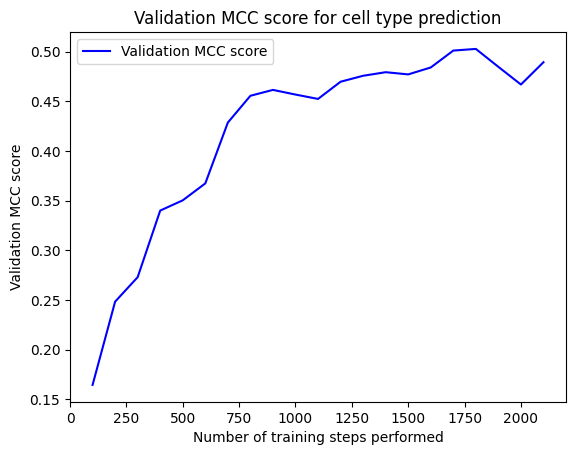

In [22]:
plt.plot(steps, eval_mcc_score, 'b', label='Validation MCC score')
plt.title('Validation MCC score for cell type prediction')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation MCC score')
plt.legend()

# save plot to working directory
plt.savefig('./figures/MCC_DHS.png', bbox_inches='tight')

plt.show()

In [23]:
curve_evaluation_f1_score =[[a['step'],a['eval_f1_score']] for a in trainer.state.log_history if 'eval_f1_score' in a.keys()]
eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
steps = [c[0] for c in curve_evaluation_f1_score]

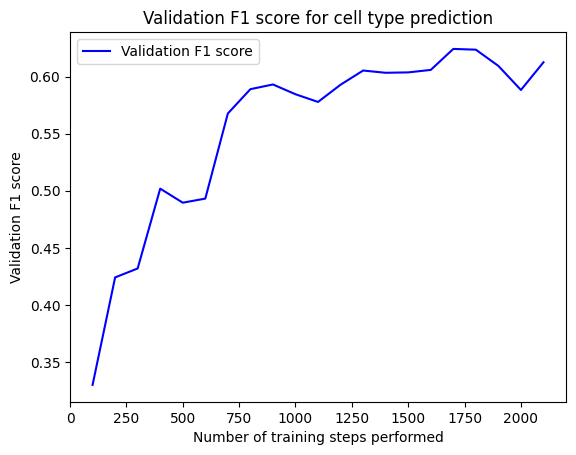

In [24]:
plt.plot(steps, eval_f1_score, 'b', label='Validation F1 score')
plt.title('Validation F1 score for cell type prediction')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation F1 score')
plt.legend()

# save plot to working directory
plt.savefig('./figures/F1_DHS.png', bbox_inches='tight')

plt.show()

In [25]:
# Compute the MCC score on the test dataset :
print(f"MCC score on the test dataset: {trainer.predict(dhs_tokenized_datasets_test).metrics['test_mcc_score']}")

MCC score on the test dataset: 0.4872104088672215


Evalutation on the left out test dataset

In [26]:
trainer.evaluate(dhs_tokenized_datasets_test)

{'eval_loss': 1.0035597085952759,
 'eval_mcc_score': 0.4872104088672215,
 'eval_f1_score': 0.6103462037859321,
 'eval_precision': 0.6234503539958676,
 'eval_recall': 0.6124161073825504,
 'eval_accuracy': 0.6124161073825504,
 'eval_runtime': 51.3946,
 'eval_samples_per_second': 186.304,
 'eval_steps_per_second': 2.919,
 'epoch': 2.33983286908078}

### Save the model to the working directory

In [28]:
tokenizer.save_pretrained("./finetuned-DHS-nucleotide-transformer-model")
model.save_pretrained("./finetuned-DHS-nucleotide-transformer-model")